In this example, we provide how to run DaTaConTrol on the Ground collision avoidance scenario
First, DaTaControl need to be installed (The dependencies installed by csaf already include the dependencies required by DaTaReachControl):
```
cd DaTaReachControl
python -m pip install -e .
```

Then, we import the necessary headers

In [1]:
from csaf.core.system import System
import csaf_f16.components as f16c
import csaf.utils as csafutils
import csaf_f16.models.ofcllc as ofcllc
from csaf_f16.plot import plot_simple, plot_llc
import numpy as np
import typing

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


Let's consider a scenario of an aircraft falling from a low altitude with high downward pitch angle

In [2]:
# We want to avoid crashing with the ground
initial = [ 540.0, # vt
            0.037027160081059704, # alpha [rad]
            0.0, # beta[rad]
            45*np.pi/180.0, # roll [rad]
            -85*np.pi/180.0, # pitch [rad]
            -45*np.pi/180.0, # yaw [rad]
            0.0, # p [rad/s]
            0.0, # q [rad/s]
            0.0, # r [rad/s]
            0.0, # pn [m]
            0.0, # pe [e]
            3600.0, # h [ft]
            9.0] # pow

We create the component corresponding to the low-level controller implemented in DaTaControl

In [3]:
class F16OFCLlcComponent(f16c.F16LlcComponent):
    """ This component extends the LLC controller defined in the library
    """
    name = "F16 On The Fly Control: Low Level Controller"
    sampling_frequency = 100.0
    flows = {
        "outputs": ofcllc.model_output,
        "states": ofcllc.model_state_update
    }
    initialize = ofcllc.model_init

class F16OFCDemo(System):
    components = {
        "plant": f16c.F16PlantComponent,
        "llc": F16OFCLlcComponent,
        "autopilot": f16c.F16GcasComponent
    }

    connections = {
        ("llc", "inputs_pstates"): ("plant", "states"),
        ("llc", "inputs_poutputs"): ("plant", "outputs"),
        ("llc", "inputs_coutputs"): ("autopilot", "outputs"),
        ("plant", "inputs"): ("llc", "outputs"),
        ("autopilot", "inputs_poutputs"): ("plant", "outputs"),
        ("autopilot", "inputs_pstates"): ("plant", "states")
    }

    priority: typing.Optional[typing.Sequence[str]] = None

We create the component corresponding to the low-level controller implemented by the default LQR controller. This will be needed for comparisons of the control strategies.

In [4]:
class F16LQRComponent(f16c.F16LlcComponent):
    """ This component extends the LLC controller defined in the library
    """
    name = "F16 LQR Controller"
    sampling_frequency = 100.0

class F16OLQRDemo(System):
    components = {
        "plant": f16c.F16PlantComponent,
        "llc": F16LQRComponent,
        "autopilot": f16c.F16GcasComponent
    }

    connections = {
        ("llc", "inputs_pstates"): ("plant", "states"),
        ("llc", "inputs_poutputs"): ("plant", "outputs"),
        ("llc", "inputs_coutputs"): ("autopilot", "outputs"),
        ("plant", "inputs"): ("llc", "outputs"),
        ("autopilot", "inputs_poutputs"): ("plant", "outputs"),
        ("autopilot", "inputs_pstates"): ("plant", "states")
    }

    priority: typing.Optional[typing.Sequence[str]] = None

We define a function to run trajectories from the above controllers for a fixed duration $T=15s$

In [5]:
def run_sim(controller):
    sys = controller()
    sys.set_state('plant', initial)
    trajs = sys.simulate_tspan(tspan=(0.0, 15.0),  show_status=True)
    return trajs

We simulate the obstacle avoidance scenario using DaTaControl. First two iterations are SLOW because of Numba requiring to procompile the functions.
`[TODO] Improve this jit functionality.`

In [6]:
trajs_ofc = run_sim(F16OFCDemo)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4503/4503 [00:19<00:00, 226.09it/s]


[For DaTaControl] We show results for a simulated F16 plant, controller and an autopilot. DaTaControl is able to avoid the collision while LQR fails.

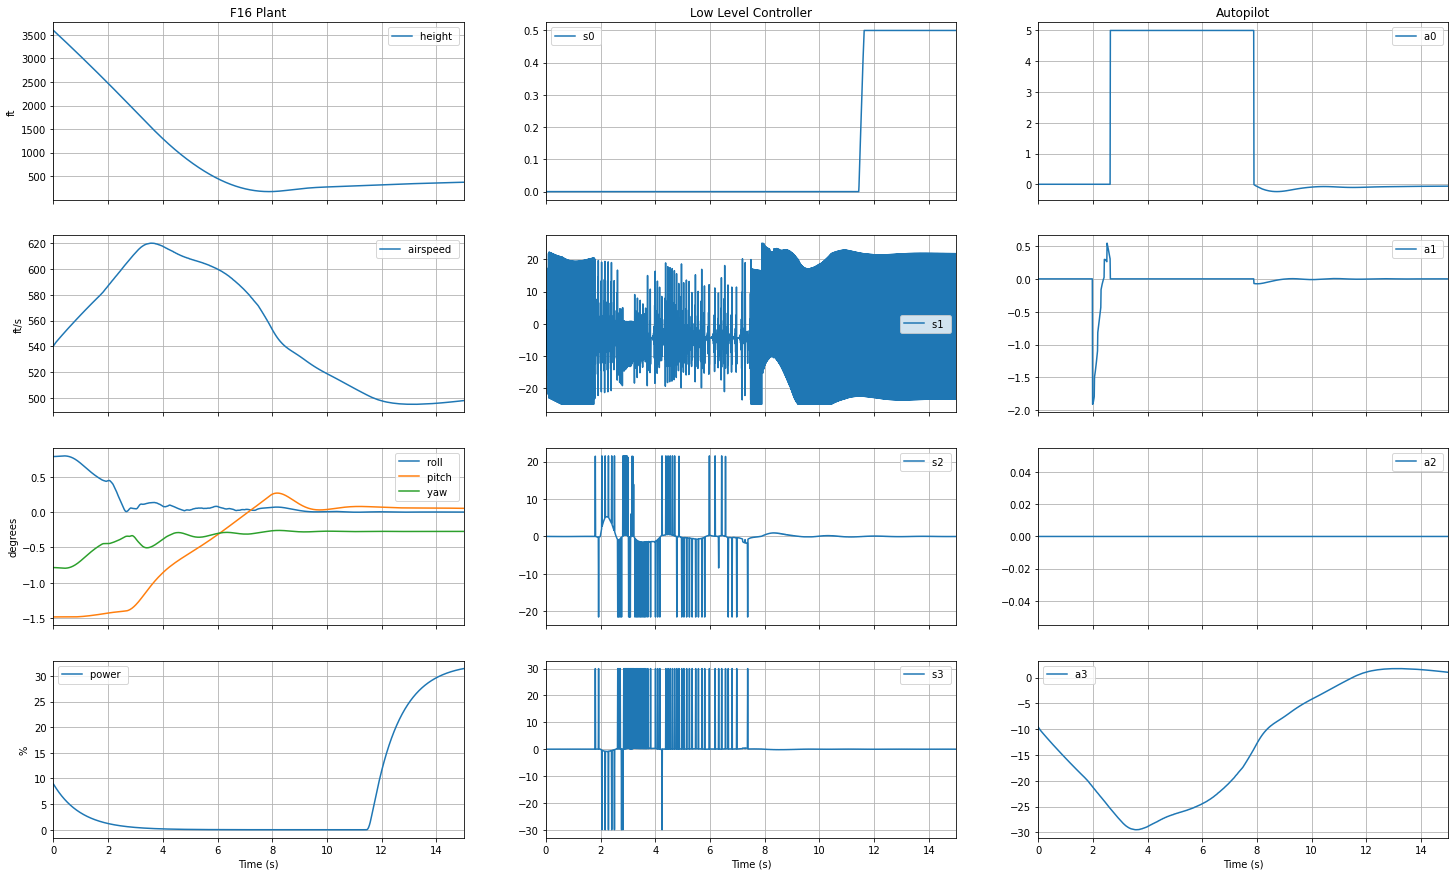

In [7]:
_fig_1_ofc = plot_simple(trajs_ofc)

[For DaTaControl] Plot reference tracking of LLC

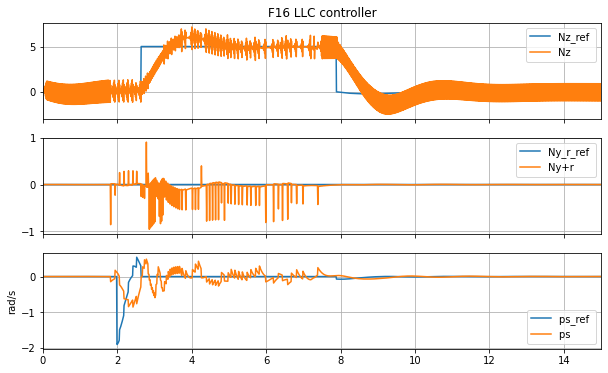

In [8]:
_fig_2_ofc = plot_llc(trajs_ofc)

We simulate the obstacle avoidance scenario using LQR

In [9]:
trajs_lqr = run_sim(F16OLQRDemo)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4503/4503 [00:02<00:00, 2052.28it/s]


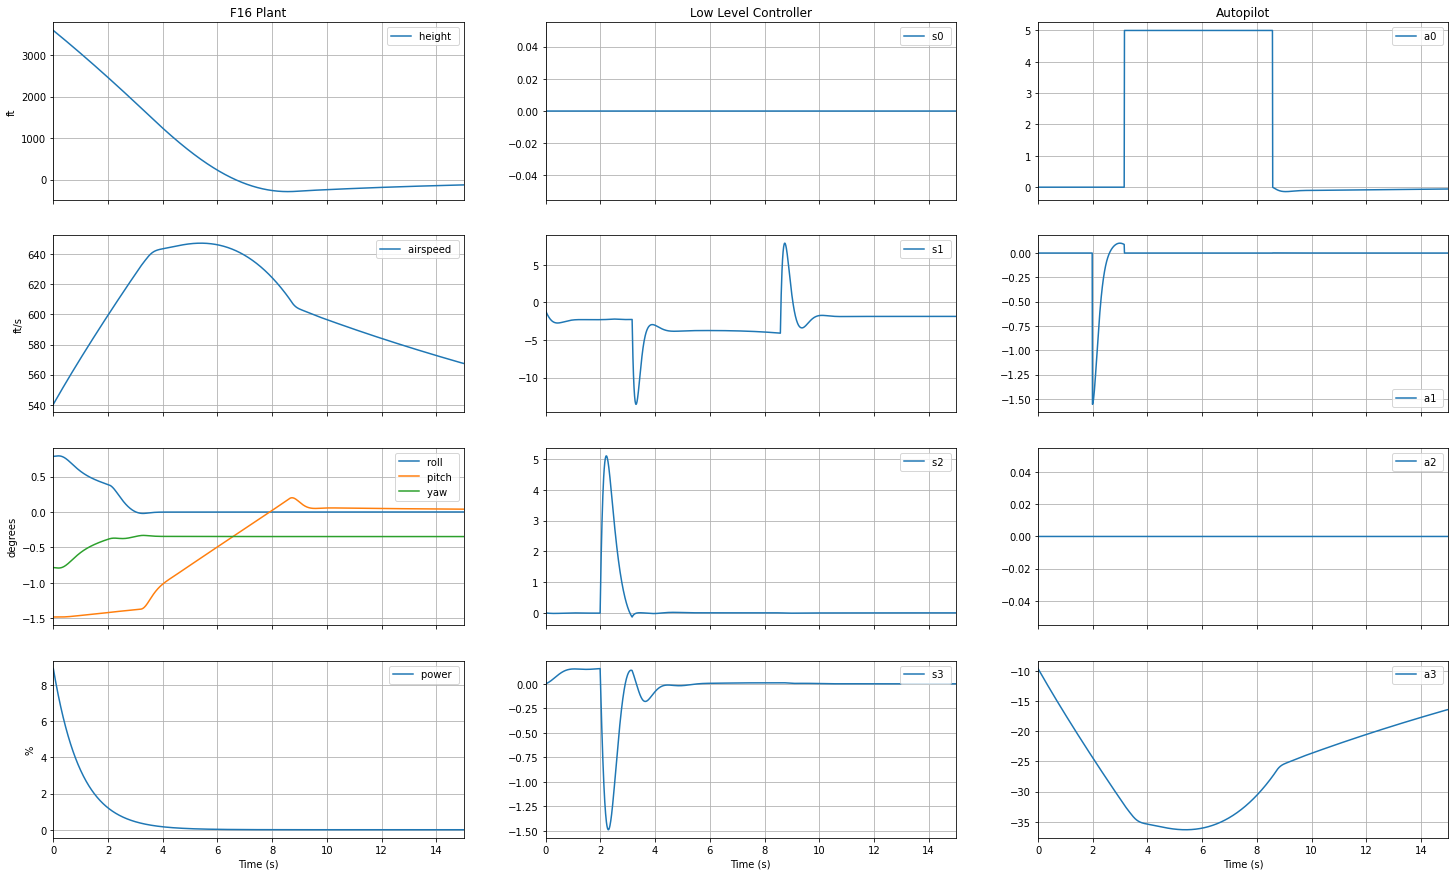

In [10]:
_fig_1_lqr = plot_simple(trajs_lqr)

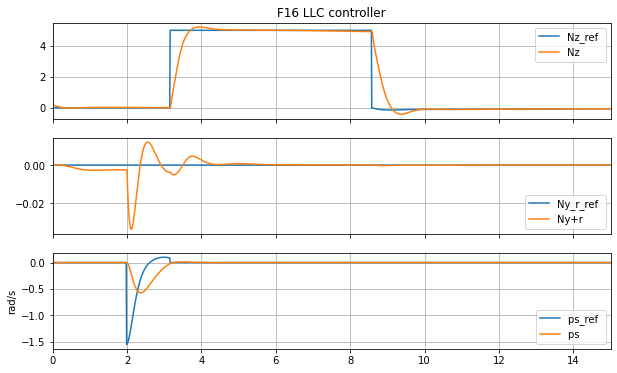

In [11]:
_fig_2_lqr = plot_llc(trajs_lqr)